In [12]:
import tensorflow as tf
print (tf.__version__)

In [19]:
import collections
import itertools
import os
import re

from typing import List, Tuple, Union, NewType, OrderedDict, Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import sklearn
import sklearn.model_selection as model_selection
import tqdm

import ocr_input

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 9)


In [14]:
InputText = NewType('InputText', Union[str, List[str]])
Label = NewType('Label', int)
DocumentRecord = NewType('DocumentRecord', Tuple[InputText, Label])
Dataset = NewType('Dataset', List[DocumentRecord])

Token = NewType('Token', str)
Vocabulary = NewType('Vocabulary', OrderedDict[Token, int])

class_names = ['email', 'form', 'handwritten', 'invoice', 'advertisement']
num_classes = len(class_names)

random_seed = 42

# Load the dataset

In [16]:
def get_dataset() -> Dataset:
    dataset_path = r".\dataset\\ocr"

    all_files = os.listdir(dataset_path)
    doc_ocr_d = {file: content for file, content in tqdm.tqdm(zip(map(lambda f: os.path.splitext(f)[0], all_files), 
                                                                  map(ocr_input.parse_xml, map(lambda p: os.path.join(dataset_path, p), all_files))),
                                                                  total=len(all_files))}

    with open(r".\dataset\label.txt", "r") as fp:
        label_d = {file: label for file, label in map(lambda line: line.split(','), fp.readlines())}

    return [(doc_ocr_d[file], label) for file, label in label_d.items()]

# TODO: use split label for this
def split_dataset(dataset: Dataset, test_size: float = 0.2, random_seed: int = random_seed) -> Tuple[List[InputText], List[InputText], List[Label], List[Label]]:
    return model_selection.train_test_split(*zip(*dataset), test_size=test_size, random_state=random_seed)
    

dataset = get_dataset()
x_train, x_test, y_train, y_test = split_dataset(dataset)

In [5]:
print(len(dataset))
print(len(x_train), len(x_test))


# Study the vocabulary

In [60]:
# Naive vocabulary counting: splitting on space character

# Conventions:
# index 0 is reserved for unknown tokens that will be mapped to `__UNK__`.
# other special token come just after (eg. `__NUM__` for numbers).
# other classic token are inserted in order for reverse dictionnary purpose.
__UNK__ = '__UNK__'

# always put __UNK__ first when redefining special char.
DEFAULT_SPECIALS = [__UNK__]

def unknown_wrapped(f):
    def wrapped(word, vocabulary=None):
        res = f(word)

        if vocabulary is not None and res not in vocabulary:
            return __UNK__
        return res
    
    return wrapped


@unknown_wrapped
def word_to_token(word: str) -> Token:
    return word


def no_preprocess(text: str) -> str:
    return text


def compute_vocabulary(input_text: List[InputText], max_size=1000, tokenize_f=word_to_token, specials=DEFAULT_SPECIALS, preprocess_f=no_preprocess) -> Tuple[Vocabulary, Counter[Token]]:
    word_occurences_d = collections.Counter(i for i in map(tokenize_f,                             # Convert each word to its token
                                                           itertools.chain(*map(str.split,         # Split words on space character ` ` and flatten the iterables 
                                                                                map(preprocess_f,  # Preprocess text before tokenization
                                                                                    x_train))))
                                            if i)                                                  # Filter out empty strings 
    # compute special tokens
    no_special = len(specials)

    vocabulary = collections.OrderedDict([(word, i) for i, (word, _) in enumerate(word_occurences_d.most_common(max_size - no_special), no_special)])

    for i, sp in enumerate(reversed(specials), 1):
        vocabulary[sp] = no_special - i
        vocabulary.move_to_end(sp, last=False)

    return vocabulary, word_occurences_d

In [56]:
def plot_vocabulary(vocabulary, n=1000):
    plt.plot(list(range(n)), [i for _, i in vocabulary.most_common(n)])

    plt.title(f"Évolution du nombre d'occurrence des {n} tokens les plus fréquents")
    plt.show()

def plot_accumulated_vocabulary(vocabulary, n=1000):
    total_tokens = sum(vocabulary.values()) / 100
    plt.plot(list(range(n)), list(itertools.accumulate(i / total_tokens for _, i in vocabulary.most_common(n))))

    plt.title(f"Évolution du nombre d'occurrences cumulé des {n} tokens les plus fréquents rapporté au nombre total de tokens")
    plt.show()

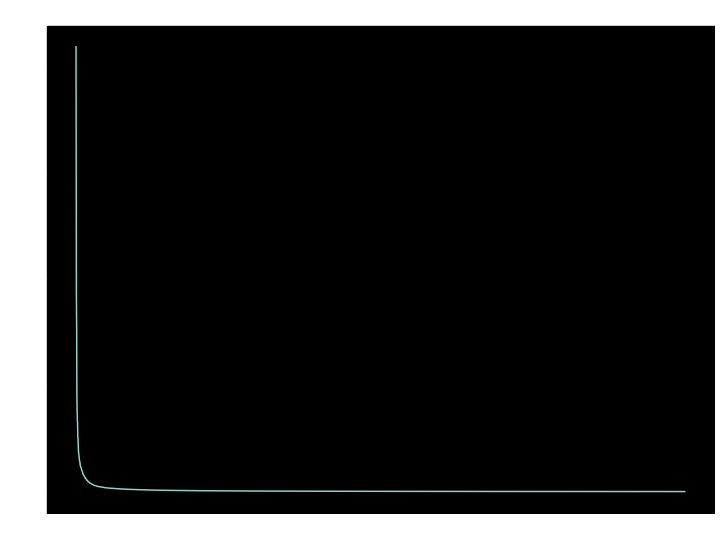

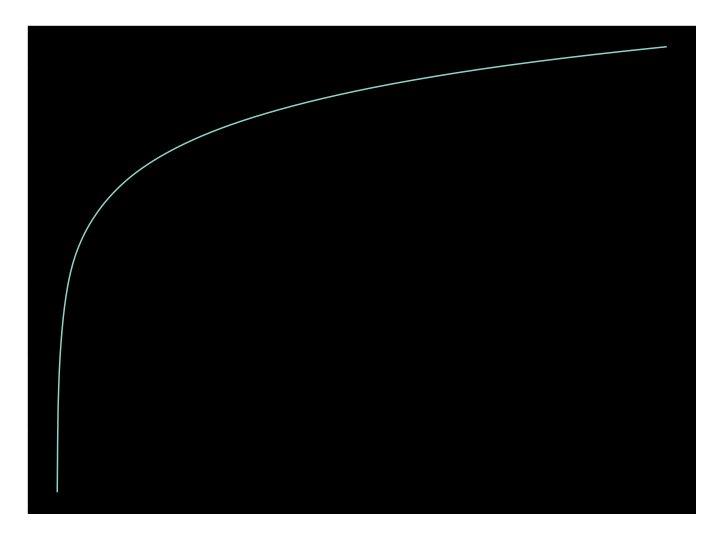

1046235
[('GC', 101), ('In', 102), ('VOLUME', 103), ('8', 104), ('m', 105), ('__', 106), ('No.', 107), ('all', 108), ('Tobacco', 109), ('we', 110), ('Date:', 111), ('w', 112), ('0.00', 113), ('"', 114), ('11', 115), ('J.', 116), ('=', 117), ('has', 118), ('any', 119), ('(', 120), ('TOBACCO', 121), ('SHARE', 122), ('00', 123), ('...', 124), ('y', 125), ('+', 126), ('PRICE', 127), ('CTN', 128), ('FP', 129), ('IN', 130), ('New', 131), ('To:', 132), ('Total', 133), ('BAT', 134), ('----', 135), ('V', 136), ('~.', 137), ('ON', 138), ('INVOICE', 139), ('d', 140), ('our', 141), ('NO.', 142), ('20', 143), ('`', 144), ('Date', 145), ('c', 146), ('SV', 147), ('v', 148), ('From:', 149), ('which', 150), ('would', 151), ('If', 152), ('x', 153), ('!', 154), ('30', 155), ('R.', 156), ('FOR', 157), ('Subject:', 158), ('®', 159), ('Z', 160), ('cigarette', 161), (')', 162), ('other', 163), ('G', 164), ('Y', 165), ('12', 166), ('may', 167), ('EQUIV', 168), ('per', 169), ('p', 170), ('if', 171), ('U', 172)

In [57]:
vocabulary, word_count = compute_vocabulary(x_train, max_size=10**4)
plot_vocabulary(word_count, n=10000)
plot_accumulated_vocabulary(word_count, n=10000)
print(len(word_count))

print(list(vocabulary.items())[101:300])

## We must reduce vocabulary size

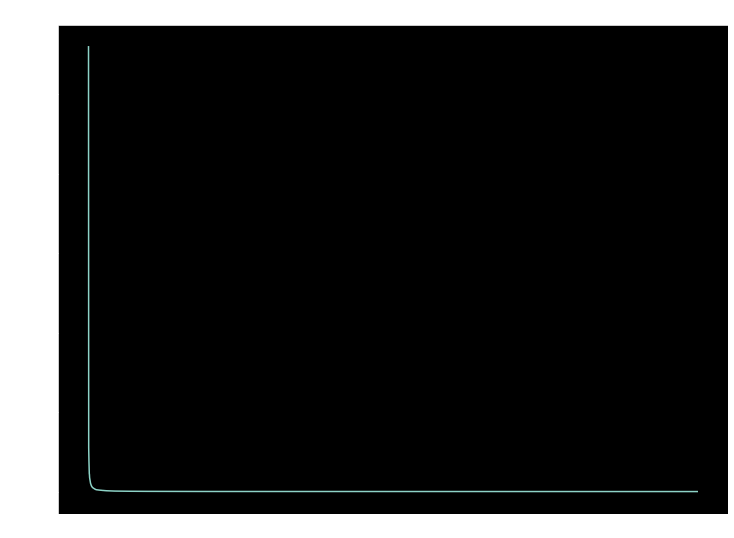

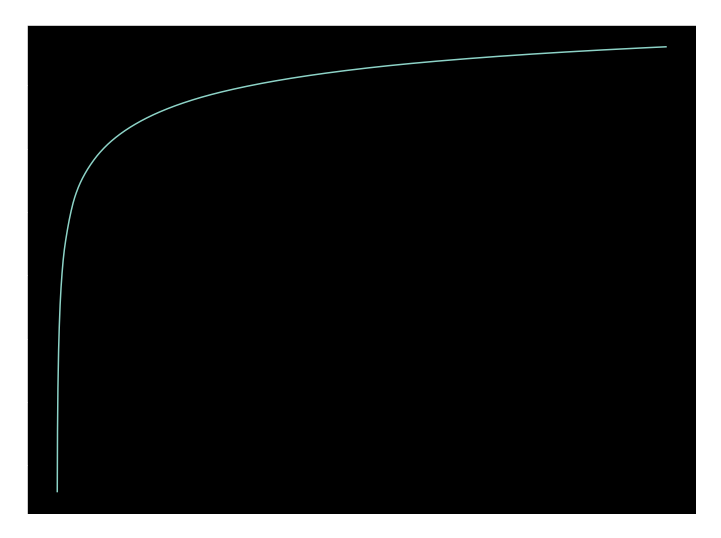

575951


In [61]:
@unknown_wrapped
def word_to_token_lower(word: str) -> Token:
    return word.lower()

def regex_preprocess(text: str) -> str:
    text = re.sub(r"([.?,!:])", r" \1 ", text)  # Add an extra space before punctuation (usefull in english)
    return re.sub(r"[^a-zA-Z0-9.?,!:$£€@#/\-\+\\\*]", " ", text)  # Remove any non basic character

vocabulary, word_count = compute_vocabulary(x_train, max_size=10**4, tokenize_f=word_to_token_lower, preprocess_f=regex_preprocess)
plot_vocabulary(word_count, n=10000)
plot_accumulated_vocabulary(word_count, n=10000)
print(len(word_count))